In [1]:
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav

import glob, os, shutil, sys, random
import numpy as np

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

NUMBER_MFCC = 13           # Number of MFCCs
NUMBER_FRAMES = 299        # Numer of Frames
NUMBER_TESTSAMPLES = 40    # Number of Testsamples
BATCH_SIZE = 5             # Batch Size
CLASSES = 7
 

In [3]:
# Samplerate of the input
SAMPLERATE = 16000

# NFFT - This is the frequency resolution
# By default, the FFT size is the first equal or superior power of 2 of the window size.
# If we have a samplerate of 16000 Hz and a window size of 32 ms, we get 512 samples in each window.
# The next superior power would be 512 so we choose that
NFFT = 512

# Size of the Window
WINDOW_SIZE = 0.032

# Window step Size = Window-Duration/8 - Overlapping Parameter
WINDOW_STEP = 0.004

# Preemph-Filter to reduce noise
PREEMPH = 0.97

In [4]:
os.chdir("/home/smu/Desktop/RNN/speakers_short")

for aud in glob.glob("*.wav"):
    (rate,sig) = wav.read(aud)
    mfcc_feat = mfcc(sig, rate, winlen=WINDOW_SIZE, winstep=WINDOW_STEP, nfft=NFFT)
    emotion = "N"
    if "W" in aud:
        emotion = "W"
    elif "L" in aud:
        emotion = "L"
    elif "E" in aud:
        emotion = "E"
    elif "A" in aud:
        emotion = "A"
    elif "F" in aud:
        emotion = "F"
    elif "T" in aud:
        emotion = "T"
    featurefile = "../train_data/" + aud + "_" + emotion
    np.save(featurefile, mfcc_feat)


In [5]:
path = "/home/smu/Desktop/RNN/train_data/"
moveto = "/home/smu/Desktop/RNN/test_data/"

for filename in os.listdir(moveto):
    file_path = os.path.join(moveto, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
        
for x in range(NUMBER_TESTSAMPLES):
    random_file=random.choice(os.listdir("/home/smu/Desktop/RNN/train_data"))
    src = path + random_file
    dst = moveto + random_file
    shutil.move(src,dst)


In [19]:
data_train_data = []
label_train_data = []
ltr = []

os.chdir("/home/smu/Desktop/RNN/train_data")

for txtfile in glob.glob("*.npy"):
    
    temp = np.load(txtfile)
    temp = np.delete(temp, (0), axis=0)
    data_train_data.append(temp)
        
 
    if "W" in txtfile:
        array = np.full(NUMBER_FRAMES, 0)
        label_train_data.append(array)
        ltr.append(0)
    elif "L" in txtfile:
        array = np.full(NUMBER_FRAMES, 1)
        label_train_data.append(array)
        ltr.append(1)
    elif "E" in txtfile:
        array = np.full(NUMBER_FRAMES, 2)
        label_train_data.append(array)
        ltr.append(2)
    elif "A" in txtfile:
        array = np.full(NUMBER_FRAMES, 3)
        label_train_data.append(array)
        ltr.append(3)
    elif "F" in txtfile:
        array = np.full(NUMBER_FRAMES, 4)
        label_train_data.append(array)
        ltr.append(4)
    elif "T" in txtfile:
        array = np.full(NUMBER_FRAMES, 5)
        label_train_data.append(array)
        ltr.append(5)
    elif "N" in txtfile:
        array = np.full(NUMBER_FRAMES, 6)
        label_train_data.append(array)
        ltr.append(6)
        


features_train = tf.convert_to_tensor(data_train_data)
labels_train = tf.convert_to_tensor(label_train_data)
ltr = tf.convert_to_tensor(ltr)
ltr = utils.to_categorical(ltr)

labeled_train_data = tf.data.Dataset.from_tensors((features_train, ltr))

print(labeled_train_data)


<TensorDataset shapes: ((495, 299, 13), (495, 7)), types: (tf.float64, tf.float32)>


In [7]:
data_test_data = []
label_test_data = []
ltt = []

os.chdir("/home/smu/Desktop/RNN/test_data")

for txtfile in glob.glob("*.npy"):
    
    
    temp = np.load(txtfile)
    temp = np.delete(temp, (0), axis=0)
    data_test_data.append(temp)
        
 
    if "W" in txtfile:
        array = np.full(NUMBER_FRAMES, 0)
        label_test_data.append(array)
        ltt.append(0)
    elif "L" in txtfile:
        array = np.full(NUMBER_FRAMES, 1)
        label_test_data.append(array)
        ltt.append(1)
    elif "E" in txtfile:
        array = np.full(NUMBER_FRAMES, 2)
        label_test_data.append(array)
        ltt.append(2)
    elif "A" in txtfile:
        array = np.full(NUMBER_FRAMES, 3)
        label_test_data.append(array)
        ltt.append(3)
    elif "F" in txtfile:
        array = np.full(NUMBER_FRAMES, 4)
        label_test_data.append(array)
        ltt.append(4)
    elif "T" in txtfile:
        array = np.full(NUMBER_FRAMES, 5)
        label_test_data.append(array)
        ltt.append(5)
    elif "N" in txtfile:
        array = np.full(NUMBER_FRAMES, 6)
        label_test_data.append(array)
        ltt.append(6)
        


features_test = tf.convert_to_tensor(data_test_data)
labels_test = tf.convert_to_tensor(label_test_data)
ltt = tf.convert_to_tensor(ltt)
ltt = utils.to_categorical(ltt)

labeled_test_data = tf.data.Dataset.from_tensors((features_test, ltt))

print(labeled_test_data)

<TensorDataset shapes: ((40, 299, 13), (40, 7)), types: (tf.float64, tf.float32)>


In [8]:
model = tf.keras.Sequential()
model.add(layers.LSTM((100), input_shape=(299, 13), return_sequences=False))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45600     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 56,407
Trainable params: 56,407
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(features_train, ltr, epochs=60, batch_size=64, validation_data=(features_test, ltt))

Epoch 1/60
8/8 [==============================] - 2s 269ms/step - loss: 2.0679 - accuracy: 0.1677 - val_loss: 1.9964 - val_accuracy: 0.2250
Epoch 2/60
8/8 [==============================] - 2s 230ms/step - loss: 1.8772 - accuracy: 0.2384 - val_loss: 1.9389 - val_accuracy: 0.2500
Epoch 3/60
8/8 [==============================] - 2s 226ms/step - loss: 1.7725 - accuracy: 0.3131 - val_loss: 1.8977 - val_accuracy: 0.2750
Epoch 4/60
8/8 [==============================] - 2s 224ms/step - loss: 1.6844 - accuracy: 0.3556 - val_loss: 1.8682 - val_accuracy: 0.2750
Epoch 5/60
8/8 [==============================] - 2s 227ms/step - loss: 1.6243 - accuracy: 0.4141 - val_loss: 1.8433 - val_accuracy: 0.3000
Epoch 6/60
8/8 [==============================] - 2s 225ms/step - loss: 1.5654 - accuracy: 0.4283 - val_loss: 1.8307 - val_accuracy: 0.3250
Epoch 7/60
8/8 [==============================] - 2s 225ms/step - loss: 1.4968 - accuracy: 0.4687 - val_loss: 1.7991 - val_accuracy: 0.3500
Epoch 8/60
8/8 [====

In [12]:
import pyaudio
import wave
import time

# Samplerate of the input
SAMPLERATE = 48000

# NFFT - This is the frequency resolution
# By default, the FFT size is the first equal or superior power of 2 of the window size.
# If we have a samplerate of 16000 Hz and a window size of 32 ms, we get 512 samples in each window.
# The next superior power would be 512 so we choose that
NFFT = 512

# Format to read in audio data
FORMAT = pyaudio.paInt16

# Size of the Window
WINDOW_SIZE = 0.032

# Window step Size = Window-Duration/8 - Overlapping Parameter
WINDOW_STEP = 0.004

# Preemph-Filter to reduce noise
PREEMPH = 0.97
# Input-Device
INPUT_DEVICE = "AT2020 USB: Audio (hw:3,0)" # Name of the input device

# Chunk - Each second we calculate 1/0.004 featuresets, so to get the chunk it has to be samplerate/(1/Windowstep)
CHUNK = int(SAMPLERATE/(1/WINDOW_STEP))
print(CHUNK)

# Record Seconds
RECORD_SECONDS = 5

# Lookup the index of the desired Input-Device, make sure jack is running
pa = pyaudio.PyAudio()
chosen_device_index = -1
for x in range(0,pa.get_device_count()):
    info = pa.get_device_info_by_index(x)
    # print (pa.get_device_info_by_index(x))
    if info["name"] == INPUT_DEVICE:
        chosen_device_index = info["index"]
        
print ("Chosen index: ", chosen_device_index)
pa.terminate()

192
Chosen index:  9


(['Wut', 'Langeweile', 'Ekel', 'Angst', 'Freude', 'Trauer', 'Neutral'],
 [5.077765672467649e-05,
  0.0064206672832369804,
  0.0005578955169767141,
  0.0001853248686529696,
  8.640124724479392e-05,
  0.9903648495674133,
  0.0023340065963566303])

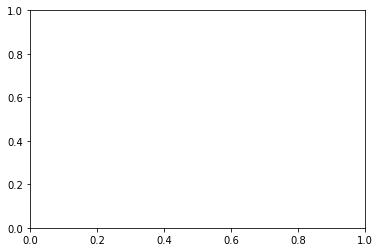

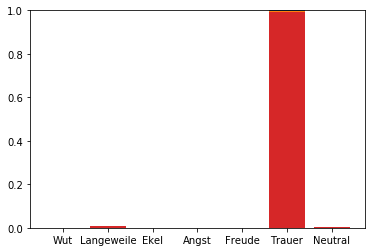

In [18]:
from itertools import cycle, islice
import matplotlib.pyplot as plt

plt.ion()

class DynamicUpdate():
    #Suppose we know the x range
    min_x = 0.0
    max_x = 1.0
    SAMPLERATE = 48000
    NFFT = 512
    FORMAT = pyaudio.paInt16
    WINDOW_SIZE = 0.032
    WINDOW_STEP = 0.004
    PREEMPH = 0.97
    RECORD_SECONDS = 5

    
    def __init__(self, model, device):
        self.varw = 0.0
        self.varl = 0.0
        self.vare = 0.0
        self.vara = 0.0
        self.varf = 0.0
        self.vart = 0.0
        self.varn = 0.0
        self.model = model
        self.inputdevice = device
        self.CHUNK = int(self.SAMPLERATE/(1/self.WINDOW_STEP))

    def on_launch(self, xdata, ydata):
        #Set up plot
        self.figure, self.ax = plt.subplots()
        self.figure.canvas.set_window_title('Emotion Recognition')
        self.ax.set_ylim(self.min_x, self.max_x)

    def on_running(self, xdata, ydata):
        self.ax.bar(xdata, ydata)
        self.figure.canvas.draw()
        self.figure.canvas.flush_events()


    def __call__(self):
        xdata = ['Wut','Langeweile','Ekel','Angst','Freude','Trauer','Neutral']
        ydata = [self.varw,self.varl,self.vare,self.vara,self.varf,self.vart,self.varn]
        self.on_launch(xdata, ydata)
        self.on_launch(xdata, ydata)
        frames = []
        result = []
        p = pyaudio.PyAudio()
        stream = p.open(format=self.FORMAT, channels=1, rate=self.SAMPLERATE, input_device_index=self.inputdevice, input=True, frames_per_buffer=self.CHUNK)
        for i in range(0, int(self.SAMPLERATE / self.CHUNK * self.RECORD_SECONDS)):
            data = stream.read(self.CHUNK, exception_on_overflow = False)
            decoded = np.frombuffer(data, 'int16')
            mfcc_feat = mfcc(decoded, samplerate=self.SAMPLERATE/3, winlen=self.WINDOW_SIZE, winstep=self.WINDOW_STEP, nfft=self.NFFT)
            if len(frames) < 299:
                frames.append(mfcc_feat)        
            elif len(frames) >= 299:
                predict_test = tf.convert_to_tensor(frames)
                predict_test = tf.transpose(predict_test, [1, 0, 2])
                result = model.predict(predict_test)
                ydata = [result.item(0), result.item(1), result.item(2), result.item(3), result.item(4), result.item(5), result.item(6)]
                self.on_running(xdata, ydata)
                frames = []            
        
        stream.stop_stream()
        stream.close()
        p.terminate()

d = DynamicUpdate(model, chosen_device_index)
d()

In [1]:
import matplotlib.pyplot as plt
from pandas import DataFrame
from itertools import cycle, islice
import numpy as np
import random
import time

p = pyaudio.PyAudio()
stream = p.open(format=FORMAT, channels=1, rate=SAMPLERATE, input_device_index=chosen_device_index, input=True, frames_per_buffer=CHUNK)
frames = []
result = []

for i in range(0, int(SAMPLERATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK, exception_on_overflow = False)
    decoded = np.frombuffer(data, 'int16')
    mfcc_feat = mfcc(decoded, samplerate=SAMPLERATE/3, winlen=WINDOW_SIZE, winstep=WINDOW_STEP, nfft=NFFT)    
    if len(frames) < 299:
        frames.append(mfcc_feat)        
    elif len(frames) >= 299:
        predict_test = tf.convert_to_tensor(frames)
        predict_test = tf.transpose(predict_test, [1, 0, 2])
        result = model.predict(predict_test)
        frames = []
        frames.append(mfcc_feat)
        print(result)


stream.stop_stream()
stream.close()
p.terminate()
print(result)



plt.ion()

class DynamicUpdate():
    #Suppose we know the x range
    min_x = 0.0
    max_x = 1.0
    
    def __init__(self, w, l, e, a, f, t, n):
        self.varw = w
        self.varl = l
        self.vare = e
        self.vara = a
        self.varf = f
        self.vart = t
        self.varn = n

    def on_launch(self, xdata, ydata):
        #Set up plot
        self.figure, self.ax = plt.subplots()
        self.figure.canvas.set_window_title('Emotion Recognition')
        self.ax.set_ylim(self.min_x, self.max_x)

    def on_running(self, xdata, ydata):
        self.ax.bar(xdata, ydata)
        self.figure.canvas.draw()
        self.figure.canvas.flush_events()


    def __call__(self):
        xdata = ['Wut','Langeweile','Ekel','Angst','Freude','Trauer','Neutral']
        ydata = [self.varw,self.varl,self.vare,self.vara,self.varf,self.vart,self.varn]
        self.on_launch(xdata, ydata)
        self.on_running(xdata, ydata)
            

        return xdata, ydata

# d = DynamicUpdate(result.item(0), result.item(1), result.item(2), result.item(3), result.item(4), result.item(5), result.item(6))
d = DynamicUpdate(rr.item(0, 0), rr.item(0, 1), rr.item(0, 2), rr.item(0, 3), rr.item(0, 4), rr.item(0, 5), rr.item(0, 6))
d()

import operator
rw = rr.item(0, 0)
rl = rr.item(0, 1)
re = rr.item(0, 2)
ra = rr.item(0, 3)
rf = rr.item(0, 4)
rt = rr.item(0, 5)
rn = rr.item(0, 6)

rlist = []
rlist.append(rw)
rlist.append(rl)
rlist.append(re)
rlist.append(ra)
rlist.append(rf)
rlist.append(rt)
rlist.append(rn)

max_value = max(rlist)
max_index = rlist.index(max_value)

if max_index == 0:
    print("Wut")
elif max_index == 1:
    print("Langeweile")
elif max_index == 2:
    print("Ekel")
elif max_index == 3:
    print("Angst")
elif max_index == 4:
    print("Freude")
elif max_index == 5:
    print("Trauer")
elif max_index == 6:
    print("Neutral")

NameError: name 'rr' is not defined